<div align="center">
<img src="static/images/logo-with-name_big.svg" width="400px" alt="SemanticLens logo" align="center" />
</div>

# 🔍 Tutorial: Peeking Inside Vision Models with SemanticLens
This tutorial provides a step-by-step guide on how to use the `semanticlens` library to understand the inner workings of a pre-trained vision model. We will discover what visual 'concepts' individual neurons in the model have learned, search for these concepts using natural language, and quantify the model's interpretability.

## Goals
By the end of this tutorial, you will be able to:
1.  Understand the three core components of `semanticlens`: the Component Visualizer, the Foundation Model, and the Lens.
2.  Build a "concept database" for a model's neurons.
3.  Search for neurons that have learned a specific concept (e.g., "a car wheel") using a text prompt.
4.  Visualize what these neurons have actually learned.
5.  Calculate scores like "clarity" to evaluate the model's interpretability.

## Core Idea

<div align="center">
  <img src="static/images/overview-figure.svg" width="90%" alt="Overview figure" align="center" />
  <p>
  Overview of the SemanticLens framework as introduced in our <a href="https://www.nature.com/articles/s42256-025-01084-w"> research paper.</a>

  </p>
</div>

The core idea of `semanticlens` is to map the incomprehensible internal components of a model you want to analyze (Model M) into the meaningful, multimodal space of a powerful foundation model (Model F, e.g., CLIP).
This is done in three steps:
1.  **Collect**: For each neuron in Model M, we find the data samples ("concept examples") that activate it the most.
2.  **Embed**: We feed these concept examples into the foundation model (F) to translate them into meaningful vector representations (embeddings).
3.  **Analyze**: Now that each neuron is represented by a meaningful vector, we can treat it like a searchable database of the model's internal knowledge.

## 1. Setup: Importing Libraries and Configuring the Environment

In [1]:
import torch
import timm
import semanticlens as sl
from semanticlens.component_visualization import aggregators
from semanticlens.foundation_models import ClipMobile
from semanticlens.component_visualization import ActivationComponentVisualizer
from semanticlens.utils.log_setup import setup_colored_logging

from torchvision.transforms import v2 as transforms

# Set up logging for better feedback
setup_colored_logging("INFO")

# Configure device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/home/berend/code/semanticlens/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. Preparing the Model and Data

> ⚠️ **Note:**  
> At its core, `semanticlens` builds a representation of a model’s components based on a dataset.
> For best results, **it should be applied to the same dataset the model was trained on**.
> Otherwise, some components may be misrepresented or remain unexplained, since important input features might be missing.
> 
> In this tutorial, we analyze the model `"resnet50d.a1_in1k"`, which was trained on the ImageNet dataset.
> To run a meaningful analysis with `semanticlens`, you will need access to ImageNet, which can be downloaded here: [image-net.org](https://www.image-net.org).
> 
> Please set the variable `IMAGENET_PATH` to the path of either the train or val folder.
> 
> If downloading ImageNet is not feasible, you can instead use a proxy dataset by setting `IMAGENET_PATH=None`.
> Keep in mind, however, that the resulting insights will likely be limited, and any conclusions should be considered preliminary.

In [2]:
IMAGENET_PATH = None  # replace with path to your local ImageNet1k train or test directory

First, we need to load the model we want to analyze and our data. One of the key design patterns in `semanticlens` is the use of **two versions of a dataset**:
 1.  `dataset_model`: This dataset has the specific transformations (e.g.,resizing, cropping, normalization) of the model being analyzed. It's used to get the model's *activations*.
 2.  `dataset_fm`: This dataset applies only minimal preprocessing (e.g., the same resizing and cropping as the model). It is used by the foundation model to embed the images. Since foundation-model–specific transformations are applied lazily, we only perform resizing and cropping here—ensuring the foundation model sees the same input as the analyzed model.

In [3]:
# --- Load the Model to Analyze ---
# We'll use a pretrained ResNet50d model from the timm library.
model_name = "resnet50d.a1_in1k"
model = timm.create_model(model_name, pretrained=True).to(device).eval()

# It's important to give the model a name for caching purposes.
model.name = model_name

# Get the model's data configuration and transforms
data_config = timm.data.resolve_data_config({}, model=model)
model_transform = timm.data.create_transform(**data_config)

print("Model Loaded:", model_name)
print("Model Transform:", model_transform)


# --- Prepare the Datasets ---
# For this example, we'll use FakeData so it can be run without any downloads.
# To use a real dataset (like ImageNet), use the commented-out code below.

# a) Dataset for the model being analyzed

# b) Dataset for the foundation model
# We don't apply normalization, as the foundation model has its own preprocessing.
fm_transform = transforms.Compose(
    [
        transforms.Resize(data_config["input_size"][1], interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(data_config["input_size"][1]),
    ]
)

if IMAGENET_PATH is None:
    from torchvision.datasets import CIFAR10

    cache_dir = "./semanticlens_cache/data"
    dataset_model = CIFAR10(root=cache_dir, download=True, transform=model_transform)
    dataset_fm = CIFAR10(root=cache_dir, download=True, transform=fm_transform)

    print(
        "WARNING: Using CIFAR10 as a placeholder dataset. Expect limited insights into your model if you are not analyzing it on the dataset it was trained on."
    )

else:
    from torchvision.datasets import ImageFolder

    dataset_model = ImageFolder(
        root=IMAGENET_PATH,
        transform=model_transform,
    )
    dataset_fm = ImageFolder(
        root=IMAGENET_PATH,
        transform=fm_transform,
    )


print(f"\nLoaded {len(dataset_model)} samples for analysis.")

Model Loaded: resnet50d.a1_in1k
Model Transform: Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


100%|██████████| 170M/170M [00:07<00:00, 23.6MB/s] 



Loaded 50000 samples for analysis.


## 3. Initializing the Core Components of SemanticLens
Now we'll set up the three main components that will perform the analysis.
1.  **Component Visualizer**: This is responsible for finding the "concept examples" (top activating images) for each neuron in a specified layer.
2.  **Foundation Model**: This acts as the "semantic expert" that understands the meaning of images and text. We'll use `ClipMobile`.
3.  **Lens**: This is the orchestrator that uses the Component Visualizer and Foundation Model to run the full analysis workflow.

> 💡 **Tip on Compute Demands and Caching:**  
> This preprocessing can be quite compute-intensive. To address this, `semanticlens` provides smart caching: simply set the `cache_dir` argument when initializing your component-visualizer. Once preprocessing is complete, results are cached and reused—even across notebook executions—so you won't need to repeat expensive computations.
> 
> If you have limited computational resources, you can:
> - Use a smaller subject model (e.g., a lightweight ResNet or MobileNet).
> - Choose a more efficient foundation model, such as:
>   ```python
>
>   fm = sl.foundation_models.OpenClip(url="RN50", pretrained="openai", device=device)
>   ```
> - Analyze a subset of your dataset instead of the full set.
>
> **Note:** Best results are obtained using the full dataset and high-performance foundation models. Reducing compute may limit the interpretability and accuracy of your analysis.

In [4]:
# Specify the layer of the model we want to analyze.
layer_to_analyze = "layer4"
# Directory to store cached results
cache_dir = "./semanticlens_cache"

# 1. Initialize the Component Visualizer
# This class finds the images that most activate each neuron.
cv = ActivationComponentVisualizer(
    model=model,
    dataset_model=dataset_model,
    dataset_fm=dataset_fm,
    layer_names=[layer_to_analyze],
    num_samples=20,  # Number of top-activating images to collect per neuron
    aggregate_fn=aggregators.aggregate_conv_mean,  # How to aggregate activations
    cache_dir=cache_dir,
)

# 2. Initialize the Foundation Model
# This model turns images and text into meaningful vectors.
fm = ClipMobile(device=device)

# 3. Initialize the Lens
# This class manages the whole process.
lens = sl.Lens(fm, device=device)

print("SemanticLens components initialized successfully.")


/home/berend/code/semanticlens/semanticlens/component_visualization/activation_based.py:166: MissingNameWarning: Dataset does not have a name attribute, which is required for reliable caching.
Using a fallback name: CIFAR10-113544998678188311898410275613033278485394818536900583016939339022559123068159.
  self._validate_args()
[2025-08-18 12:21:48,608|semanticlens.component_visualization.activation_based|INFO]: Results will be stored in semanticlens_cache/ActivationComponentVisualizer/CIFAR10-113544998678188311898410275613033278485394818536900583016939339022559123068159/resnet50d.a1_in1k


SemanticLens components initialized successfully.



## 4. Running the Analysis: Building the Semantic Database
Now we'll run the analysis in two steps.
1.  **Find Concept Examples**: We call `cv.run()` to collect the top-activating images for each neuron. This is computationally intensive but the results are cached, so it only runs once.
2.  **Build Semantic Database**: We call `lens.compute_concept_db()` to use the foundation model to embed the concept examples found in step 1.


In [5]:
# --- Step 1: Find top-activating images for each neuron ---
print("Finding top-activating images for each neuron...")
# This function saves its results to './semanticlens_cache', so if you run it again, it will load from the cache.
cv.run(batch_size=64)

# --- Step 2: Build the semantic database ---
print("\nBuilding the semantic database...")
# The Lens uses the foundation model to embed the concept examples. This result is also cached.
concept_db = lens.compute_concept_db(cv, batch_size=64)

print("\nAnalysis complete!")
db_shape = concept_db[layer_to_analyze].shape
print(f"Concept database for '{layer_to_analyze}' has shape: (num_neurons, num_samples, embedding_dim)")
print(f"Shape: {db_shape}")


Finding top-activating images for each neuron...


[2025-08-18 12:22:50,917|semanticlens.component_visualization.activation_caching|INFO]: Cache saved successfully to semanticlens_cache/ActivationComponentVisualizer/CIFAR10-113544998678188311898410275613033278485394818536900583016939339022559123068159/resnet50d.a1_in1k
INFO:semanticlens.component_visualization.activation_caching:Cache saved successfully to semanticlens_cache/ActivationComponentVisualizer/CIFAR10-113544998678188311898410275613033278485394818536900583016939339022559123068159/resnet50d.a1_in1k
[2025-08-18 12:22:50,918|semanticlens.component_visualization.activation_caching|INFO]: Loading cache for aggregation fn: 'aggregate_conv_mean'
INFO:semanticlens.component_visualization.activation_caching:Loading cache for aggregation fn: 'aggregate_conv_mean'
[2025-08-18 12:22:50,920|semanticlens.component_visualization.activation_caching|INFO]: Successfully loaded data for 1 layer(s) from semanticlens_cache/ActivationComponentVisualizer/CIFAR10-113544998678188311898410275613033278


Building the semantic database...


Embedding Dataset: 50048it [02:10, 383.63it/s]                           



Analysis complete!
Concept database for 'layer4' has shape: (num_neurons, num_samples, embedding_dim)
Shape: torch.Size([2048, 20, 512])


In [6]:
len(dataset_model)

50000

# 5. Exploring the Model's Knowledge
We now have our `concept_db`, which holds the internal knowledge of our model. Let's use it to explore.
## 5.1. Text Probing
We can use natural language queries to find neurons that have learned specific concepts. First, we need to aggregate our concept database to get a single representative vector per neuron (we'll take the mean).

In [13]:
# Average across the samples dimension to get one vector per neuron.
aggregated_db = {k: v.mean(dim=1) for k, v in concept_db.items()}
print(f"Aggregated DB for '{layer_to_analyze}' has shape: {aggregated_db[layer_to_analyze].shape}")

# Probe the database with a text query for the concept of "wheel".
query = "car wheel"
print(f"\nSearching for concept: '{query}'")
text_scores = lens.text_probing(query, aggregated_db, templates=["a photo of a {}"])

# Find the top 5 neurons that are most similar to our query.
top_neuron_ids = text_scores[layer_to_analyze].topk(5).indices.flatten()

print(f"Top 5 neurons for '{query}': {top_neuron_ids.tolist()}")

Aggregated DB for 'layer4' has shape: torch.Size([2048, 512])

Searching for concept: 'car wheel'
Top 5 neurons for 'car wheel': [115, 349, 1642, 41, 1467]


### 5.2. Visualizing the Results
Now for the moment of truth! Let's visualize what the neurons we found via text search have actually learned. `cv.visualize_components` will show us a grid of the top-activating images for each neuron.

In order to obtain a proper visualization we need to provide a denormalization transform either as attribute of the `cv.dataset` or as a key-word argument.

In [14]:
# create a denormalization transform
denormalization_fn = sl.utils.get_unnormalization_transform(
    mean=list(data_config["mean"]), std=list(data_config["std"])
)

Visualizing what the top 5 neurons for 'car wheel' have learned...


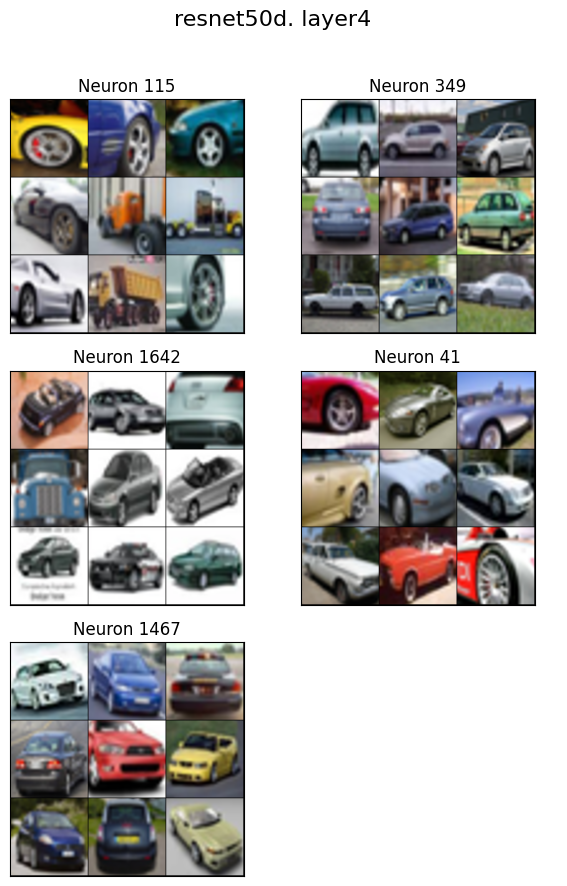

Saved visualization to semanticlens_cache/ActivationComponentVisualizer/CIFAR10-113544998678188311898410275613033278485394818536900583016939339022559123068159/resnet50d.a1_in1k/plots/layer4_115-349-1642-41-1467.png


<Figure size 640x480 with 0 Axes>

In [15]:
print(f"Visualizing what the top 5 neurons for '{query}' have learned...")
cv.visualize_components(
    component_ids=top_neuron_ids,
    layer_name=layer_to_analyze,
    n_samples=9,  # Number of images to display for each neuron
    denormalization_fn=denormalization_fn,
)

In [16]:
# lets assign the denormalization function to the cv.dataset so we dont have to pass it every time.
cv.dataset.denormalization_fn = denormalization_fn

## 6. Evaluating Interpretability
`semanticlens` also provides scores to quantify the interpretability of model components. The **Clarity** score measures how semantically consistent the concept examples for a single neuron are. A higher score means the neuron has learned a clearer, more well-defined, single concept.
Let's visualize the most and least clear neurons to get an intuition for what this score means.

Calculating clarity scores for layer 'layer4'...

Top 5 most clear neurons: [1375, 246, 901, 1000, 292]
Visualizing most clear neurons (they should represent a single, consistent concept):


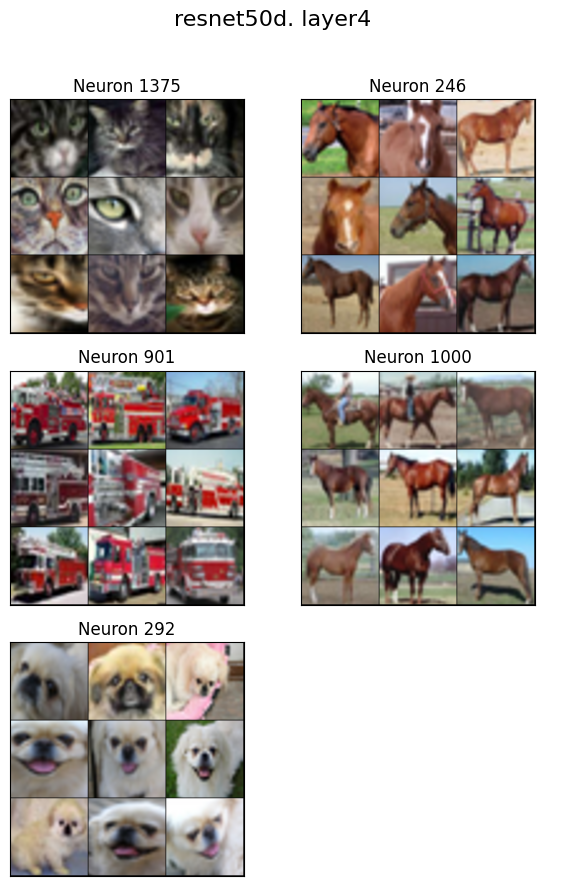

Saved visualization to semanticlens_cache/ActivationComponentVisualizer/CIFAR10-113544998678188311898410275613033278485394818536900583016939339022559123068159/resnet50d.a1_in1k/plots/layer4_1375-246-901-1000-292.png


<Figure size 640x480 with 0 Axes>

In [17]:
# Calculate clarity scores for 'layer4'
print(f"Calculating clarity scores for layer '{layer_to_analyze}'...")
clarity_scores = lens.eval_clarity(concept_db)[layer_to_analyze]

# Find the top 5 most clear neurons
most_clear_ids = clarity_scores.topk(5).indices
print(f"\nTop 5 most clear neurons: {most_clear_ids.tolist()}")
print("Visualizing most clear neurons (they should represent a single, consistent concept):")
cv.visualize_components(component_ids=most_clear_ids, layer_name=layer_to_analyze)


Top 5 least clear neurons: [627, 797, 959, 1314, 1091]
Visualizing least clear neurons (they may represent multiple concepts or noisy features):


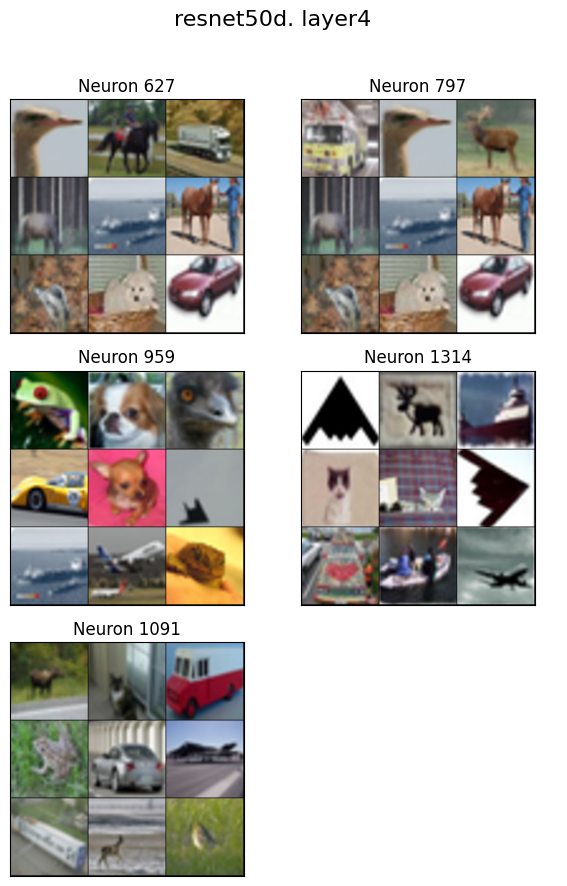

Saved visualization to semanticlens_cache/ActivationComponentVisualizer/CIFAR10-113544998678188311898410275613033278485394818536900583016939339022559123068159/resnet50d.a1_in1k/plots/layer4_627-797-959-1314-1091.png


<Figure size 640x480 with 0 Axes>

In [18]:
# Find the top 5 least clear neurons
least_clear_ids = clarity_scores.topk(5, largest=False).indices
print(f"\nTop 5 least clear neurons: {least_clear_ids.tolist()}")
print("Visualizing least clear neurons (they may represent multiple concepts or noisy features):")
cv.visualize_components(component_ids=least_clear_ids, layer_name=layer_to_analyze)


## Conclusion and Next Steps
In this tutorial, we used `semanticlens` to:
- Build a **semantic database** representing the visual concepts learned by a vision model's internal neurons.
- Successfully find the neurons responsible for a specific concept using a **text query**.
- **Visualize** the learnings of these neurons to confirm our findings.
- Quantitatively evaluate the interpretability of neurons using the **clarity score**.
### Where to go from here:
* **Different Models and Layers**: Try analyzing a different `timm` model or a different layer of the model (e.g., `layer1`, `layer2`).
* **Different Foundation Models**: Use a different foundation model, like `semanticlens.foundation_models.SigLipV2`.
* **Other Scores**: Explore `lens.eval_polysemanticity()` and `lens.eval_redundancy()` to understand other aspects of your model's interpretability.
* **Image Probing**: Use `lens.image_probing()` to search for concepts with an example image instead of text.

### Comming Soon:
* **Relevance-based Component Visualization**: Using Layer-wise Relevance Propagation not only the samples that highly activate a model component of interest can be identified but also responsible features within the images can be pin-pointed and used during the semantic embedding.
* **Activation Heatmaps**: Faithfully attributing transformer architectures is still an open research question. Instead we can use the latent activations as a proxy to identify important input featuers.
* ... (If you have additional ideas, feel free to open a pull-request or an issue.)